# 🏥🔬 Ocular Disease Recognition Using Vision Transformers (ViT) | PyTorch + HuggingFace

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3419_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/4176_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3370_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1255_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/660_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/484_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/4221_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2396_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/543_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3017_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1482_left.jpg
/kaggle/input/ocular-disease-recognit

## 📚 1. Install Required Libraries
Before starting, we need to install some important Python libraries like PyTorch, Transformers, and other helper libraries.

In [10]:
!pip install torch torchvision transformers datasets scikit-learn matplotlib seaborn

## 🛠 2. Import Necessary Packages
We now import all the libraries that will help with model building, data processing, training, evaluation, and plotting.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as transforms

from transformers import AutoFeatureExtractor, AutoModelForImageClassification

import pandas as pd
import numpy as np
import cv2
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report


## 🖼️ 3. Define Custom Dataset Class
We define a custom Dataset class to load the ocular disease dataset. This will apply preprocessing steps like CLAHE (Contrast enhancement) and get images and labels ready for training.

In [12]:
class ODIRDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, max_samples=7500):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.max_samples = max_samples
        self.image_paths = []
        self.labels = []

        self.prepare_dataset()
        
    def apply_clahe_rgb(self, img_rgb):
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        enhanced_img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        return enhanced_img

    def prepare_dataset(self):
        disease_classes = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Others']
        label_to_index = {label: idx for idx, label in enumerate(disease_classes)}
        col_to_disease = {'N': 'Normal', 'D': 'Diabetes', 'G': 'Glaucoma', 'C': 'Cataract', 'A': 'AMD', 'H': 'Hypertension', 'M': 'Myopia', 'O': 'Others'}
        
        current_count = 0
        for idx, row in self.dataframe.iterrows():
            for eye in ['Left-Fundus', 'Right-Fundus']:
                if current_count >= self.max_samples:
                    break

                img_name = row[eye]
                img_path = os.path.join(self.img_dir, img_name)
                
                if os.path.exists(img_path):
                    label = None
                    for col, disease in col_to_disease.items():
                        if row[col] == 1:
                            label = label_to_index[disease]
                            break
                    if label is None:
                        label = label_to_index['Others']

                    self.image_paths.append(img_path)
                    self.labels.append(label)
                    current_count += 1
            if current_count >= self.max_samples:
                break

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_clahe = self.apply_clahe_rgb(img_rgb)
        
        if self.transform:
            img_clahe = self.transform(img_clahe)
        
        label = self.labels[idx]
        return img_clahe, label


## 🎨 4. Define Image Transformations
We specify how to transform the images: resize to a standard shape, normalize pixel values, and prepare them for model input.

In [13]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert to [0,1]
    transforms.Normalize([0.5], [0.5])  # Optional Normalization
])


## 📂 5. Load the Dataset and Create DataLoaders
We load the CSV file and images, split the dataset into training and validation sets, and prepare DataLoaders to feed data into the model efficiently.

In [14]:
df = pd.read_csv('/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv')
image_folder = '/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images'

dataset = ODIRDataset(df, img_dir=image_folder, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [15]:
len(dataset)

7500

## 🤖 6. Load Pretrained Vision Transformer Model
We load a pretrained ViT (Vision Transformer) model from Huggingface Transformers and adjust it for 8-class classification (ocular diseases).

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "google/vit-base-patch16-224-in21k"  # SOTA Vision Transformer
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=8
)
model.to(device)


2025-04-28 19:23:10.046207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745868190.069556    1556 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745868190.076453    1556 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

## ⚙️ 7. Define Loss Function, Optimizer, and Scheduler
Set up the optimization function, loss function, and learning rate scheduler to train the model properly.

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)


## 🏋️‍♂️ 8. Create Training and Validation Loop
We create a loop to train the model for several epochs. It tracks training/validation loss and accuracy at each epoch.

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images).logits
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history


## 🚀 9. Start Model Training
We now call the training function to start the model learning from the dataset.

In [19]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)


Epoch 1/10, Train Loss: 1.5392, Train Acc: 0.4203, Val Loss: 1.4008, Val Acc: 0.4793
Epoch 2/10, Train Loss: 1.2795, Train Acc: 0.5255, Val Loss: 1.2682, Val Acc: 0.5187
Epoch 3/10, Train Loss: 1.0616, Train Acc: 0.6305, Val Loss: 1.2036, Val Acc: 0.5487
Epoch 4/10, Train Loss: 0.8069, Train Acc: 0.7530, Val Loss: 1.1528, Val Acc: 0.5920
Epoch 5/10, Train Loss: 0.5616, Train Acc: 0.8478, Val Loss: 1.2032, Val Acc: 0.5953
Epoch 6/10, Train Loss: 0.3716, Train Acc: 0.9117, Val Loss: 1.1849, Val Acc: 0.6240
Epoch 7/10, Train Loss: 0.2609, Train Acc: 0.9462, Val Loss: 1.2890, Val Acc: 0.6127
Epoch 8/10, Train Loss: 0.1742, Train Acc: 0.9718, Val Loss: 1.2854, Val Acc: 0.6280
Epoch 9/10, Train Loss: 0.1570, Train Acc: 0.9755, Val Loss: 1.2894, Val Acc: 0.6287
Epoch 10/10, Train Loss: 0.1450, Train Acc: 0.9795, Val Loss: 1.2903, Val Acc: 0.6360


## 📈 10. Plot Loss and Accuracy Curves
Visualize how the training and validation loss and accuracy changed over epochs. Helps to see if the model is overfitting or underfitting.

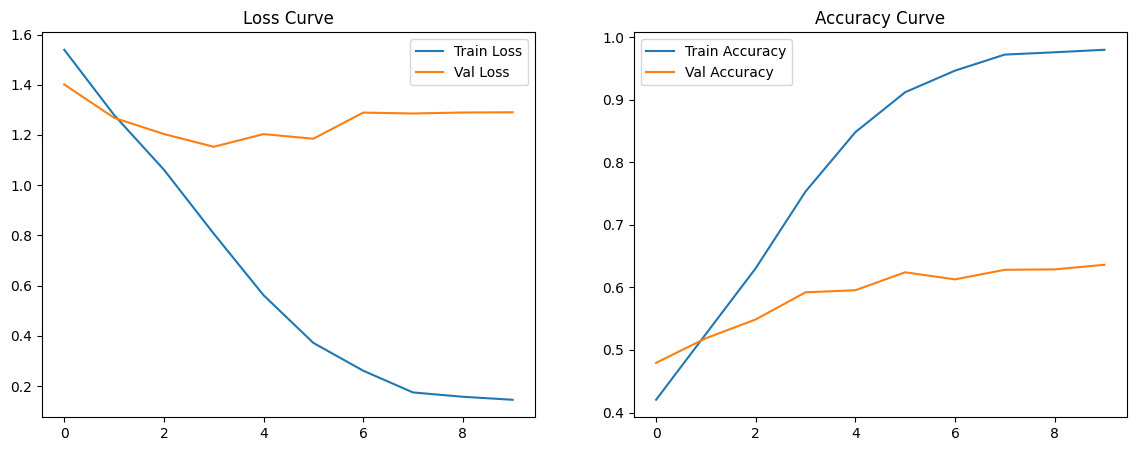

In [20]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Loss Curve')
    ax1.legend()

    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Val Accuracy')
    ax2.set_title('Accuracy Curve')
    ax2.legend()

    plt.show()

plot_history(history)


## 🧠 11. Evaluate the Model Performance
After training, evaluate the model on the validation set using metrics like confusion matrix, precision, recall, and f1-score.

              precision    recall  f1-score   support

      Normal       0.56      0.54      0.55       421
    Diabetes       0.70      0.67      0.68       537
    Glaucoma       0.55      0.44      0.49        66
    Cataract       0.70      0.61      0.66        70
         AMD       0.74      0.76      0.75        71
Hypertension       0.82      0.33      0.47        27
      Myopia       0.87      0.81      0.84        59
      Others       0.57      0.72      0.63       249

    accuracy                           0.64      1500
   macro avg       0.69      0.61      0.64      1500
weighted avg       0.64      0.64      0.63      1500



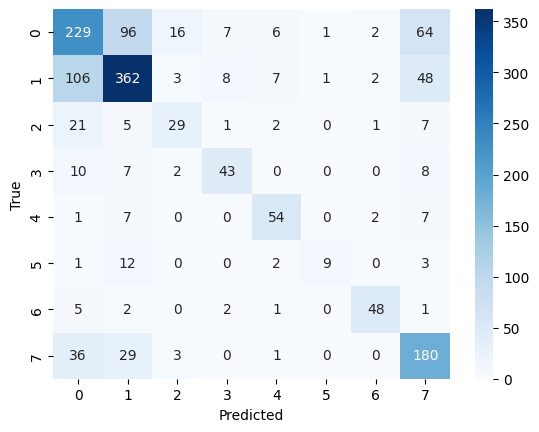

In [21]:
def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=[
        'Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Others'
    ])

    print(cr)
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

evaluate_model(model, val_loader)


## 🎲 12. Show Random Predictions from Validation Set
Randomly pick a few images from the validation set, predict their labels, and visualize them along with true labels to see how well the model is performing.

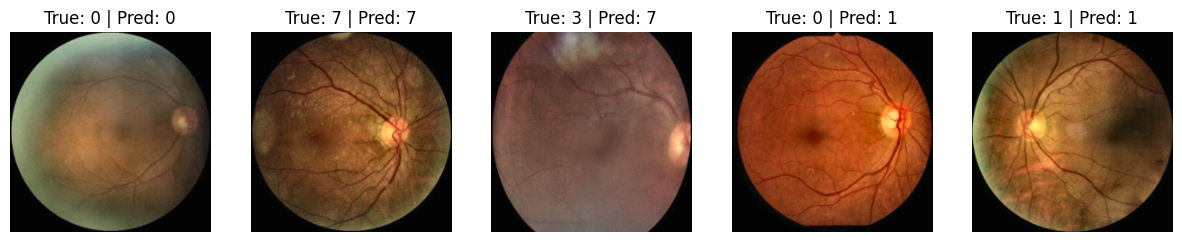

In [23]:
def show_random_predictions(model, dataset, n=5):
    model.eval()
    idxs = random.sample(range(len(dataset)), n)
    
    plt.figure(figsize=(15,10))
    for i, idx in enumerate(idxs):
        img, true_label = dataset[idx]
        img_input = img.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(img_input).logits
            pred_label = torch.argmax(outputs, dim=1).item()

        img = img.permute(1,2,0).cpu().numpy()
        img = (img * 0.5) + 0.5  # de-normalize
        
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"True: {true_label} | Pred: {pred_label}")
        plt.axis('off')

    plt.show()

show_random_predictions(model, val_dataset)
